# Preface
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

In [44]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("ggrepel")
    library("Rtsne")
    library("caret")
    library("MASS")
    
})

## Set session-specific options
options(repr.plot.width = 12, # Adjust plot width for publication purposes
        repr.plot.height = 8, # Adjust plot height for publication purposes,
        scipen = -1) # Adjust scientific notation of numbers to improve readability of plots

## List mzXML files
mzXMLs <- list.files(path = getwd(), recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

# Quality Control of Raw Data
The following injection order during analysis correspond to the order files are read using list.files. In case several batches were analysed, as vector containing an integer for each batch assignment of each sample must be given.

In [45]:
## List mzXML files
mzXMLs <- list.files(path = "ZicHILIC_pos", recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

## Aggregate meta data
sample.name <- sub(basename(mzXMLs), pattern = ".mzXML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("Control", 5), rep("alpha-PCYP", 5), 
                  rep("QC", 7))
sample.order <- c(8,10,15,7,13,16,12,9,14,6,1,2,3,4,5,11,17)
sample.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group, 
                   sample_order = sample.order, 
                   sample_batch = sample.batch, 
                   stringsAsFactors = FALSE)

## Read raw data from disk
raw <- readMSData(files = mzXMLs[order(sample.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(sample.order),]), 
                  mode = "onDisk")
## Remove column equilibration and washing phases
raw <- filterRt(raw, c(60,600))

class(raw)

print(raw)

[1] "OnDiskMSnExp"
attr(,"package")
[1] "MSnbase"

MSn experiment data ("OnDiskMSnExp")
Object size in memory: 4.99 Mb
- - - Spectra data - - -
 MS level(s): 1 
 Number of spectra: 17688 
 MSn retention times: 1:0 - 9:60 minutes
- - - Processing information - - -
Data loaded [Fri Oct 22 10:55:51 2021] 
Filter: select retention time [60-600] and MS level(s), 1 [Fri Oct 22 10:55:51 2021] 
 MSnbase version: 2.14.2 
- - - Meta data  - - -
phenoData
  rowNames: 11 12 ... 17 (17 total)
  varLabels: sample_name sample_group sample_order sample_batch
  varMetadata: labelDescription
Loaded from:
  [1] pQC_1.mzXML...  [17] pQC_7.mzXML
  Use 'fileNames(.)' to see all files.
protocolData: none
featureData
  featureNames: F01.S0117 F01.S0118 ... F17.S1156 (17688 total)
  fvarLabels: fileIdx spIdx ... spectrum (35 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'


# Inspection of Parent Compound and Internal Standard
This experiment used deuterated tryptophan as an internal standard to normalise variability introduced by injection of the samples into the mass spectrometer. Quality control in at this stage includes ensuring that both the internal standard, as well as the parent compound, have been detected properly and the within group variability is acceptable.

In [48]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(3, "Set1")[1:3])
names(group.colours) <- c("Control", "alpha-PCYP", "QC")

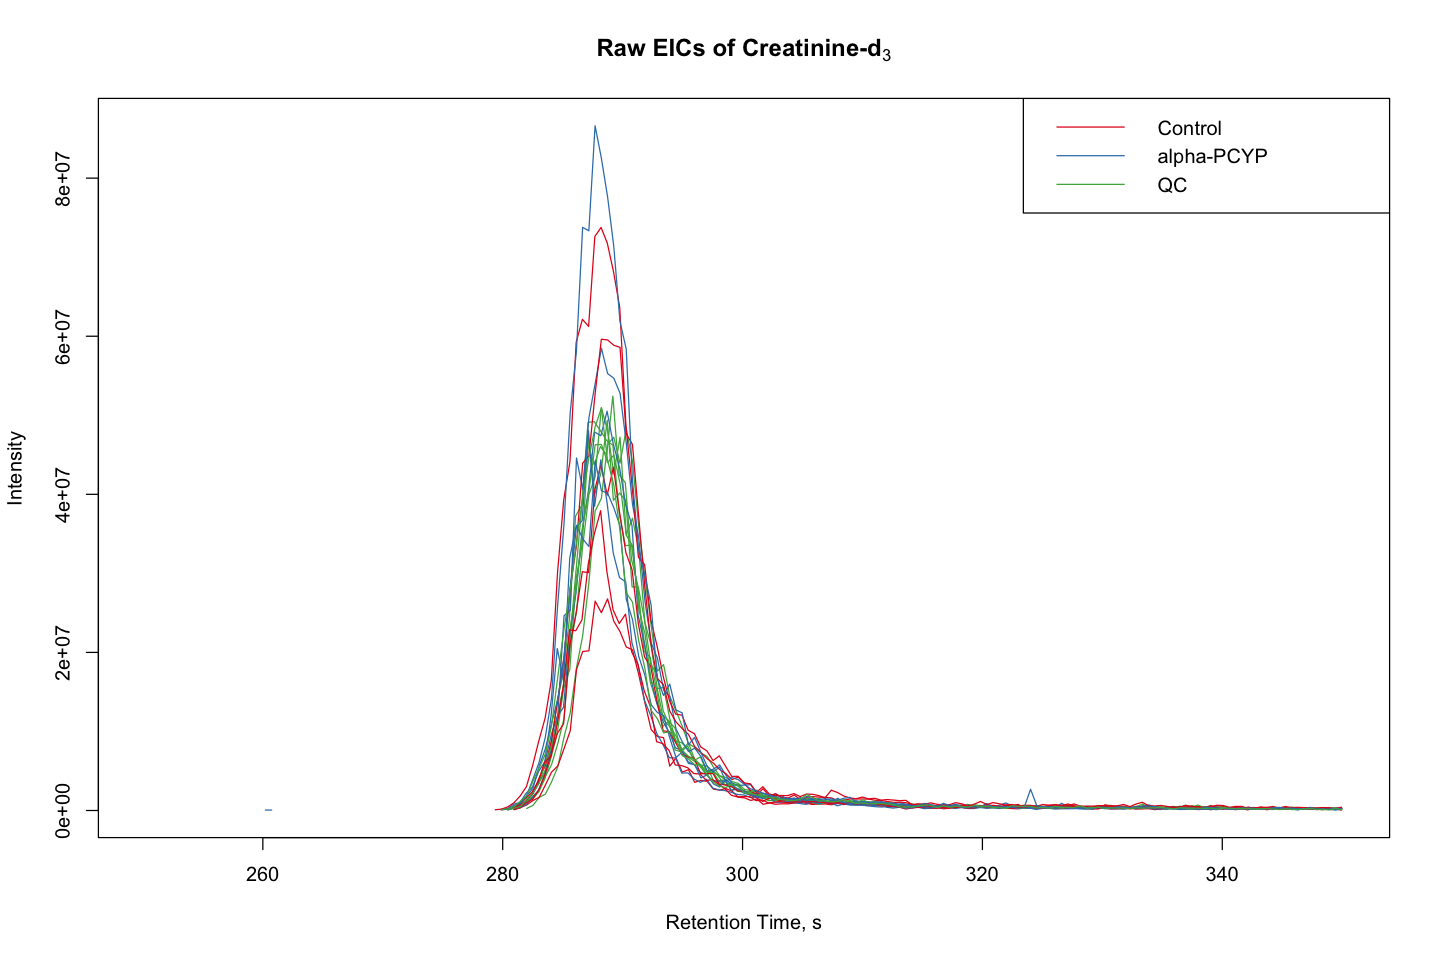

In [49]:
## Plot raw EICs of creatinine-d3 (m/z 117.0856, 25 s)
cread3.raw <- chromatogram(raw, mz = c(117.0841, 117.0871), rt = c(250, 350))

plot(cread3.raw, col = group.colours[cread3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Creatinine-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

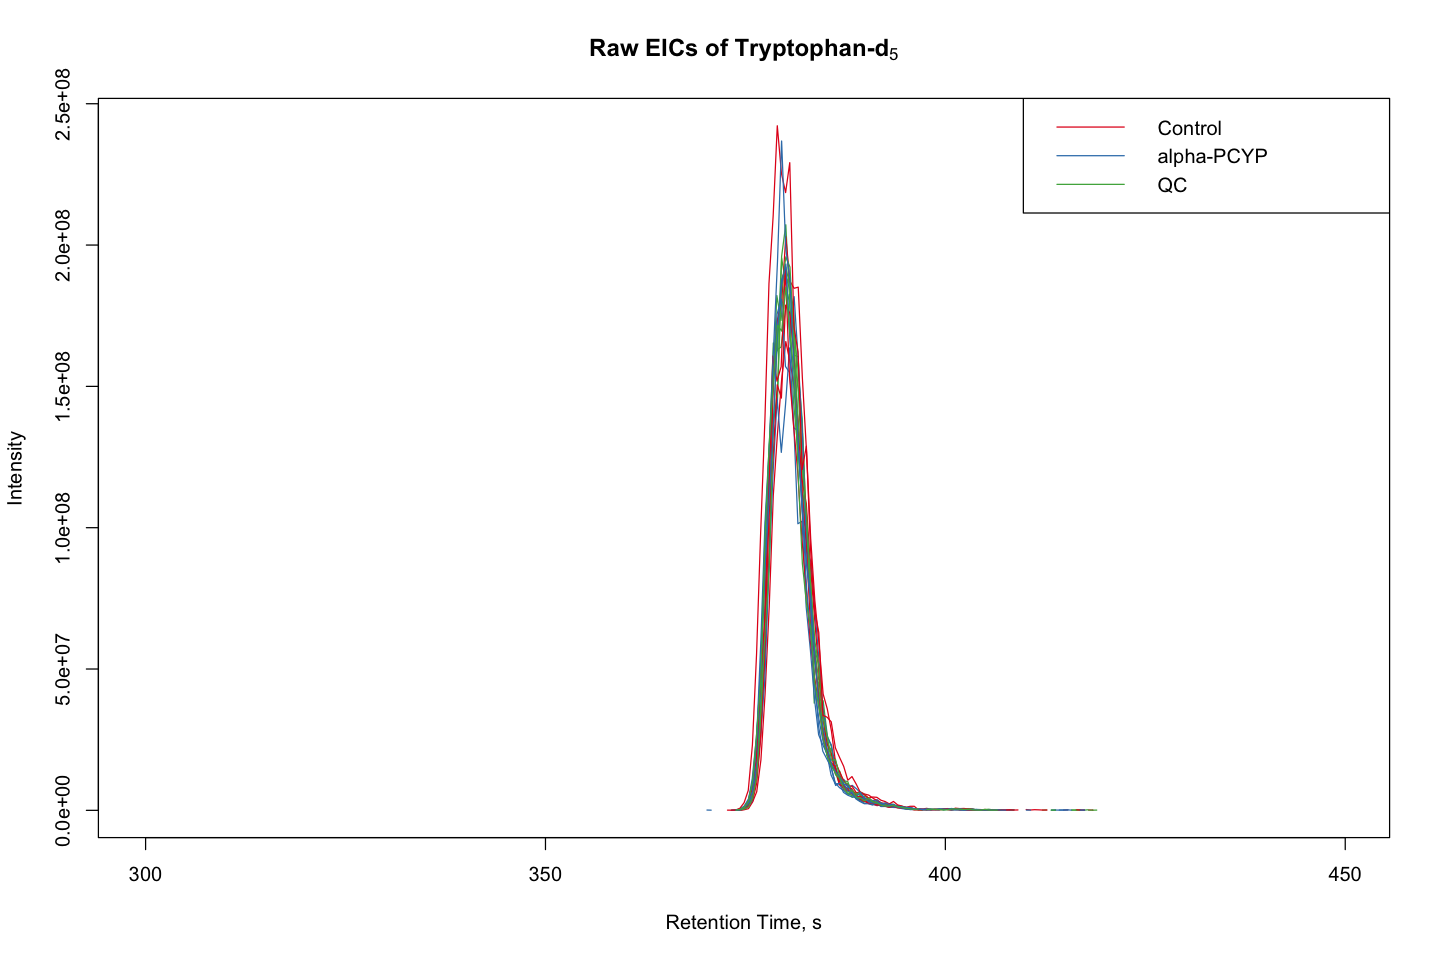

In [51]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(3, "Set1")[1:3])
names(group.colours) <- c("Control", "alpha-PCYP", "QC")


## Plot tryptophan-d5 before processing (m/z 210.1291, 168 s)
trpd5.raw <- chromatogram(raw, mz = c(210.1281, 210.1296), rt = c(300, 450))

plot(trpd5.raw, col = group.colours[trpd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of Tryptophan-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

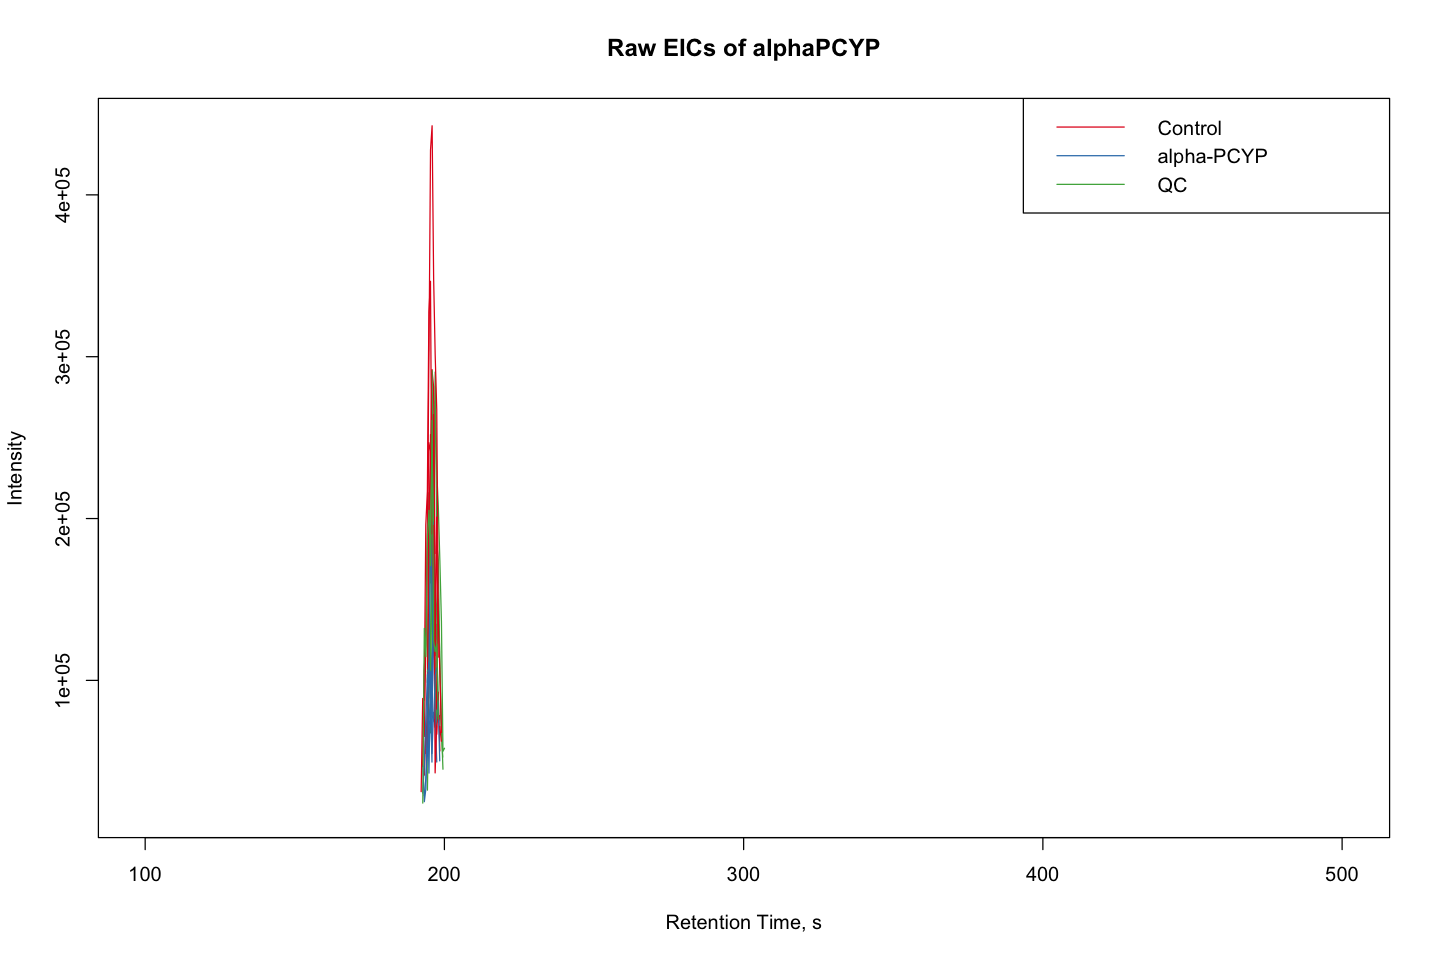

In [52]:
## Plot raw EICs of alpha-PCYP (m/z 272.2008, 25 s)
alphaPCYP.raw <- chromatogram(raw, mz = c(272.2000, 272.2015), rt = c(100, 500))

plot(alphaPCYP.raw, col = group.colours[alphaPCYP.raw$sample_group], 
     main = bquote(bold("Raw EICs of alphaPCYP")), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

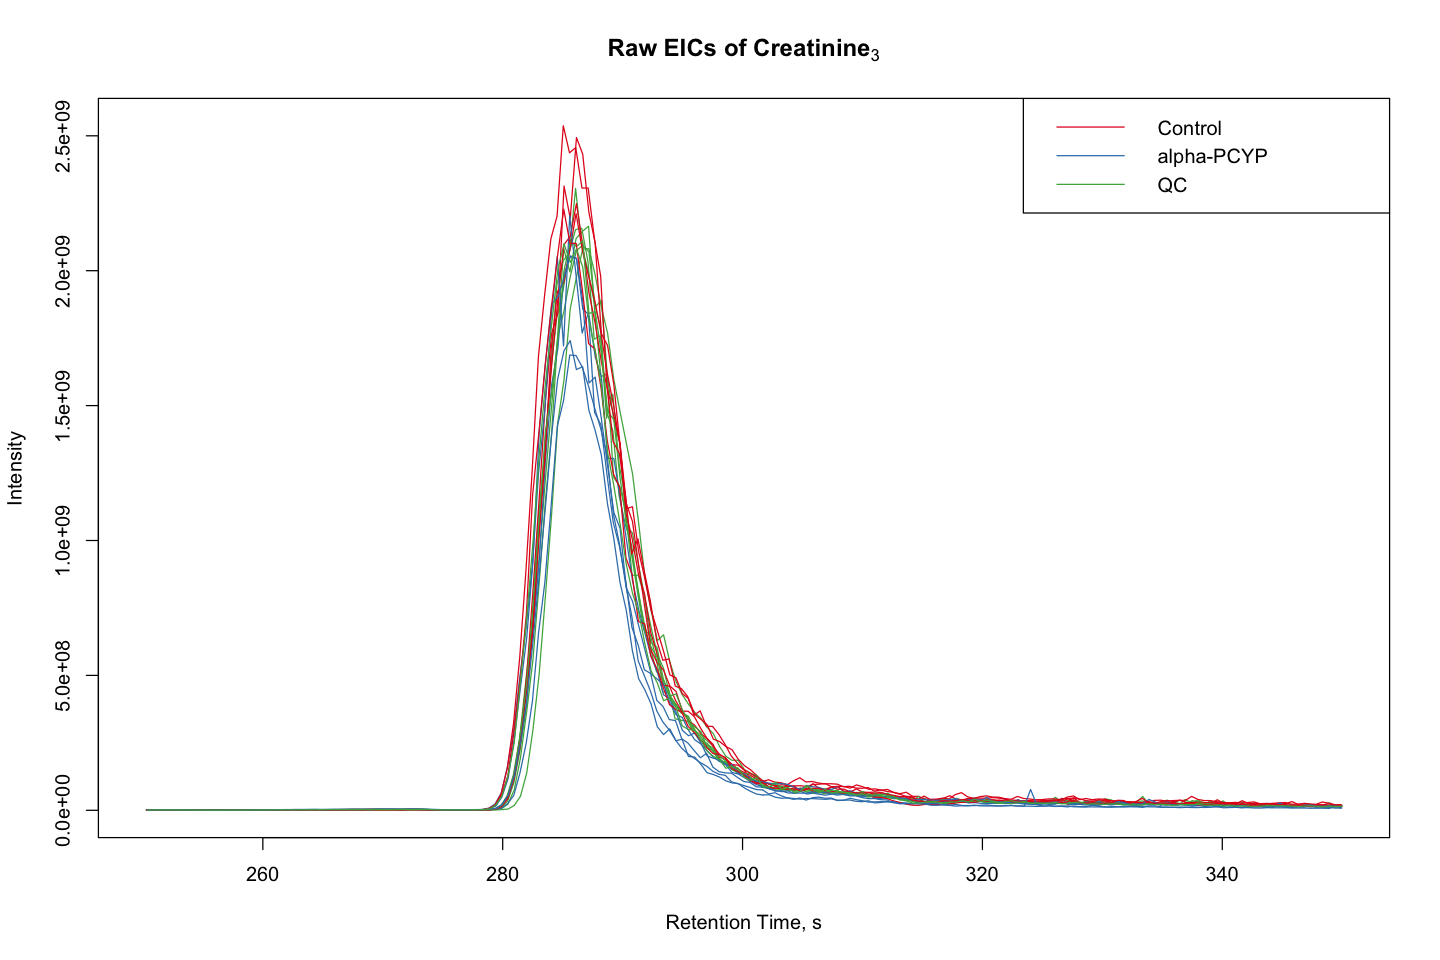

In [53]:
## Plot raw EICs of creatinine (m/z 114.0665, 25 s)
crea.raw <- chromatogram(raw, mz = c(114.0645, 114.0685), rt = c(250, 350))

plot(crea.raw, col = group.colours[crea.raw$sample_group], 
     main = bquote(bold("Raw EICs of Creatinine"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Inspect Total Ion Currents of Sample Files

Total ion currents (TICs) need to be inspected in order to ensure that chromatography and mass spectrometry have been performing properly. Quality control includes the inspection of retention time drifts within TICS and evaluation of the baselines.

In [54]:
## Get total ion chromatograms
tics <- chromatogram(raw, aggregationFun = "sum")

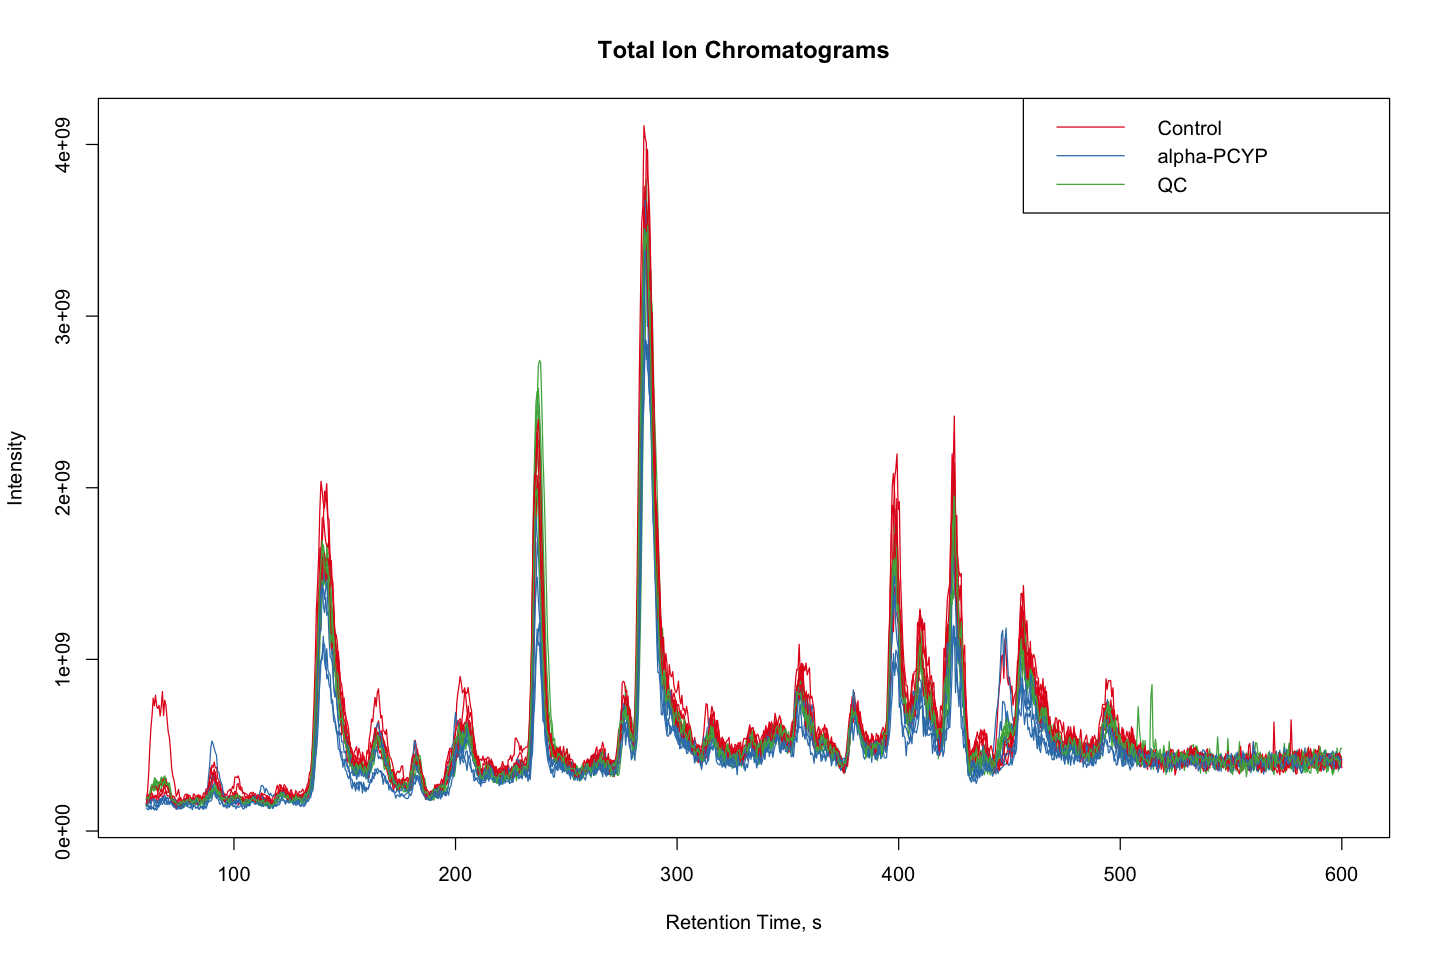

In [55]:
## Plot every total ion chromatogram of the data set
plot(tics, col = group.colours[raw$sample_group], 
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

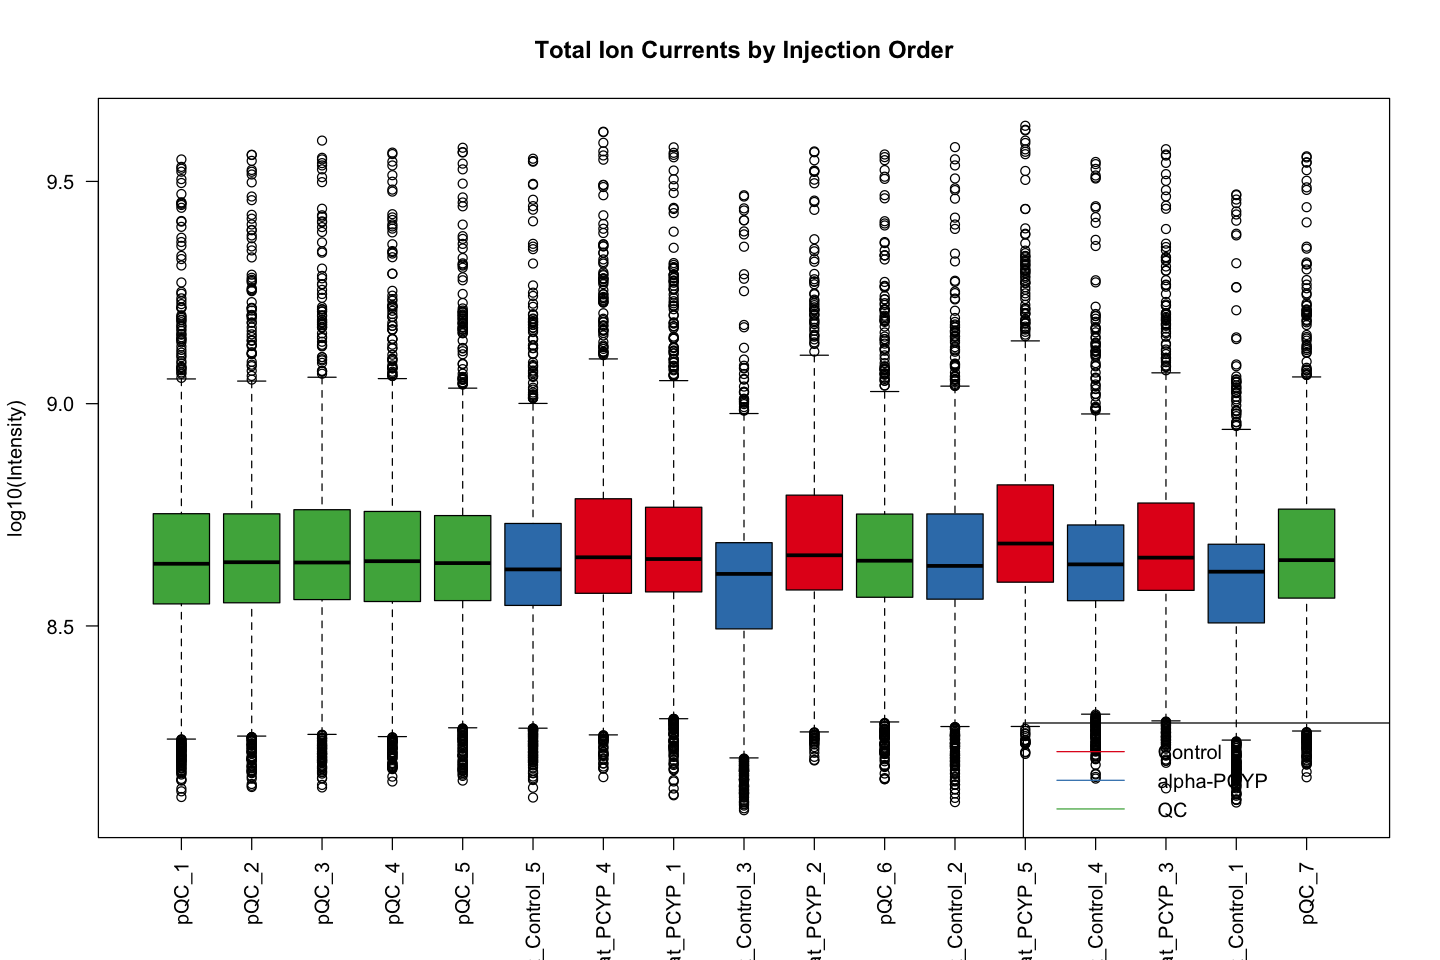

In [56]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Preprocessing of Raw Sample Files

# Peak Picking

Parameter used in this section were obtained using the one-by-one optimization performed by centWaveOpt. This approach was published at DOI: 10.1002/dta.2552 by Manier et al.

In [57]:
cwp <- CentWaveParam(peakwidth = c(8.9, 21), ppm = 1.9, snthresh = 16, 
                     mzdiff = 0.02,  prefilter = c(8, 100))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [58]:
## Define sample colours
sample.colours <- paste0(brewer.pal(3, "Set1")[1:3], "60")
names(sample.colours) <- c("Control", "alpha-PCYP", "QC")
sample.colours <- sample.colours[raw$sample_group]

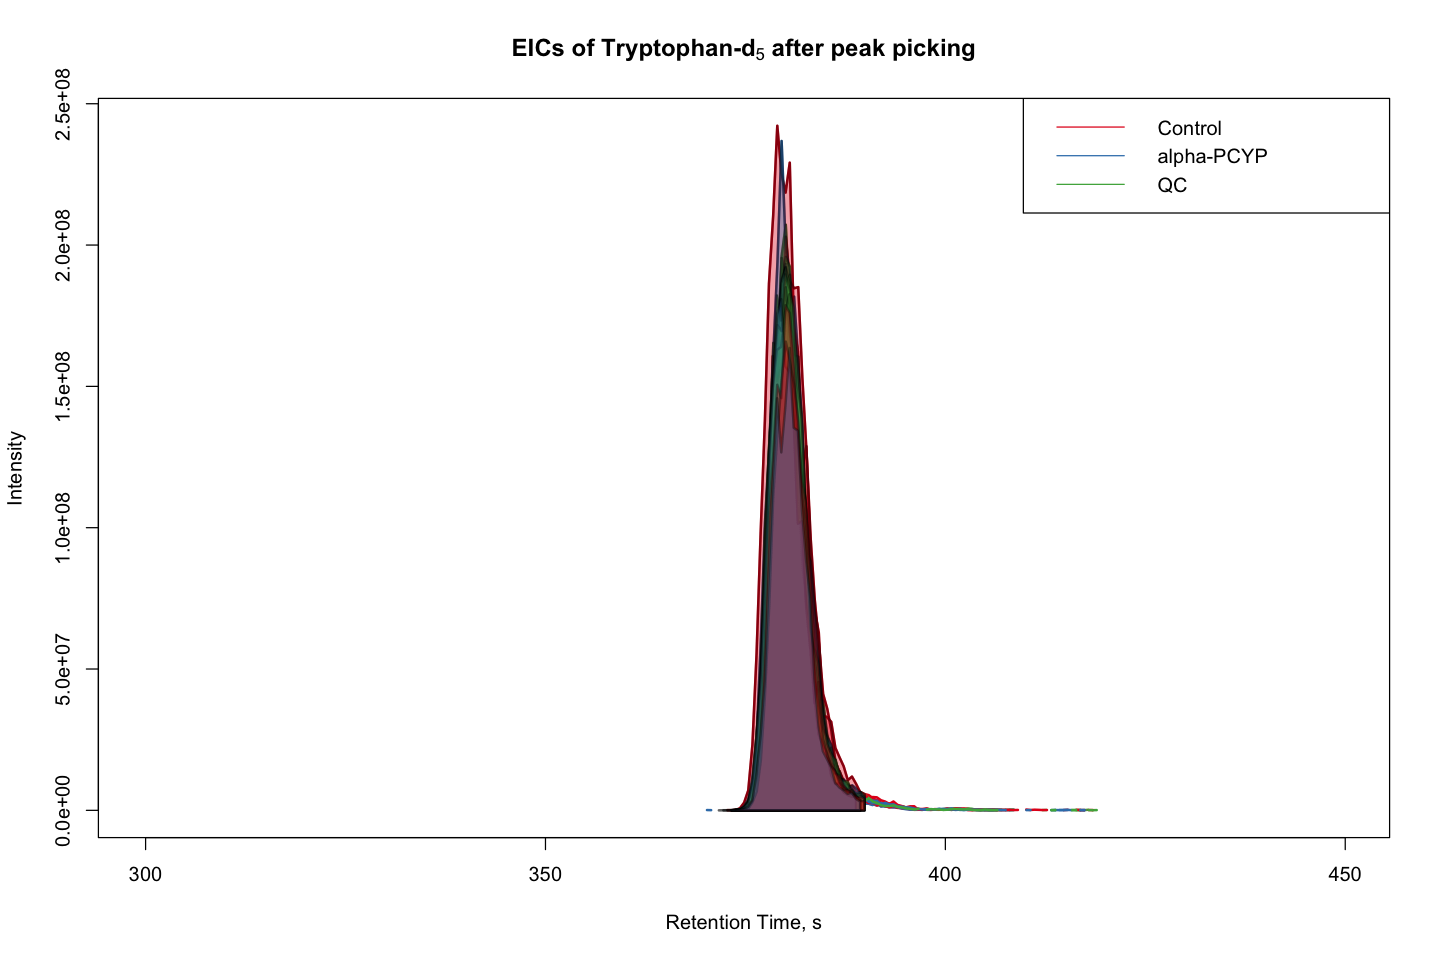

In [59]:
## Plot Tryptophan-d5 after peak picking (m/z 210.1291, 168 s)
trpd5.picked <- chromatogram(set, mz = c(210.1281, 210.1301), rt = c(300, 450)) 

plot(trpd5.picked, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.picked)[, "sample"]],
     main = bquote(bold("EICs of Tryptophan-d"[5]*" after peak picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

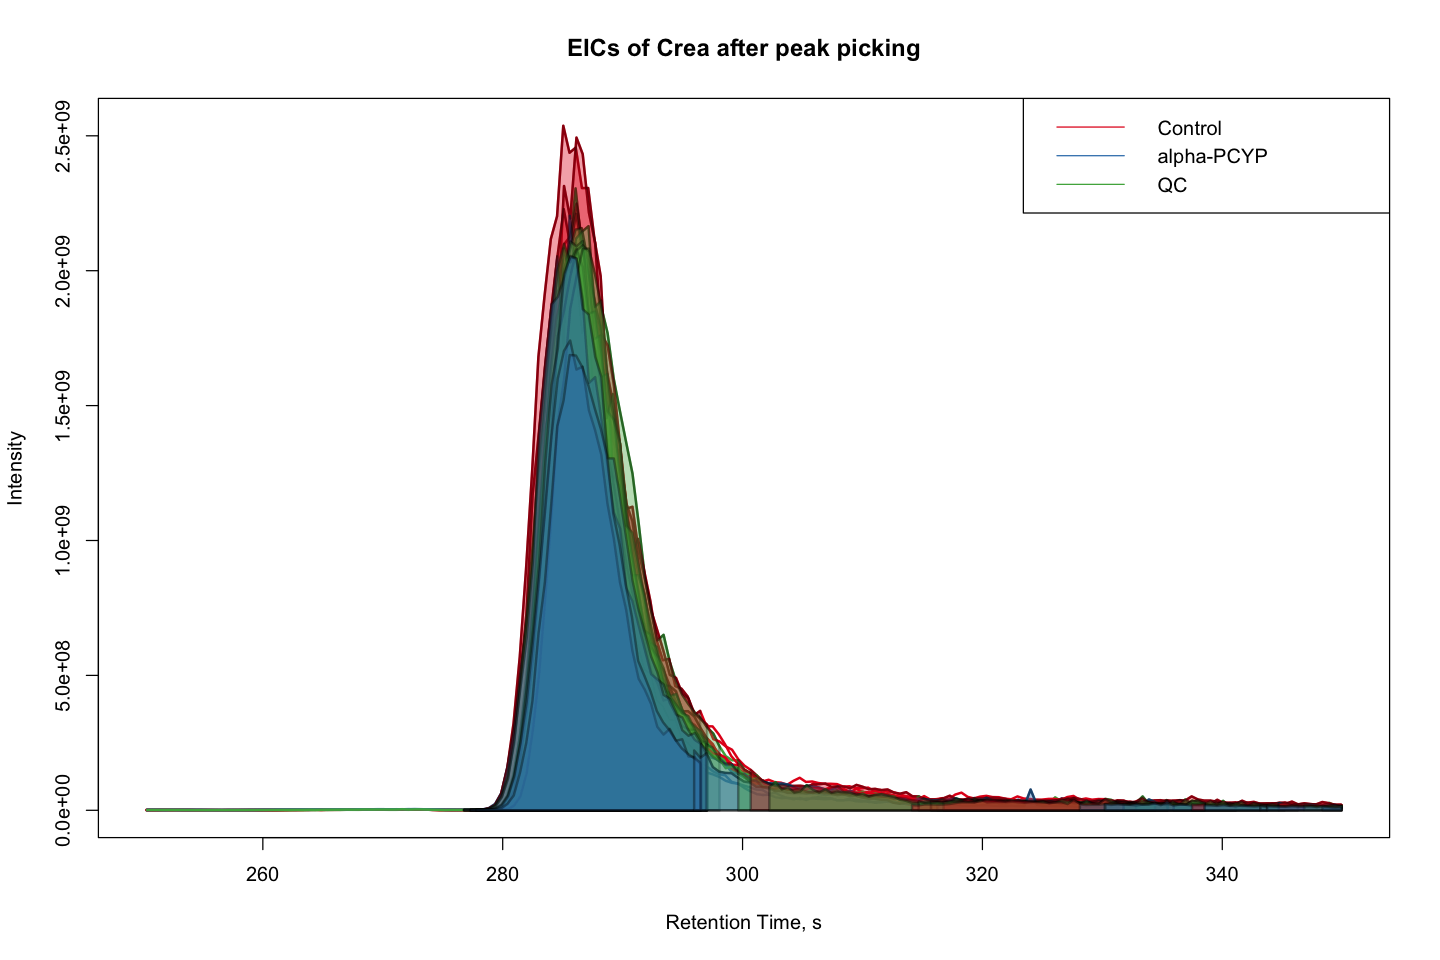

In [60]:
## Plot Crea after peak picking (m/z 114.0665, 287s)
crea.picked <- chromatogram(set, mz = c(114.0645, 114.0685), rt = c(250, 350)) 

plot(crea.picked, col = group.colours[crea.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(crea.picked)[, "sample"]],
     main = bquote(bold("EICs of Crea after peak picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

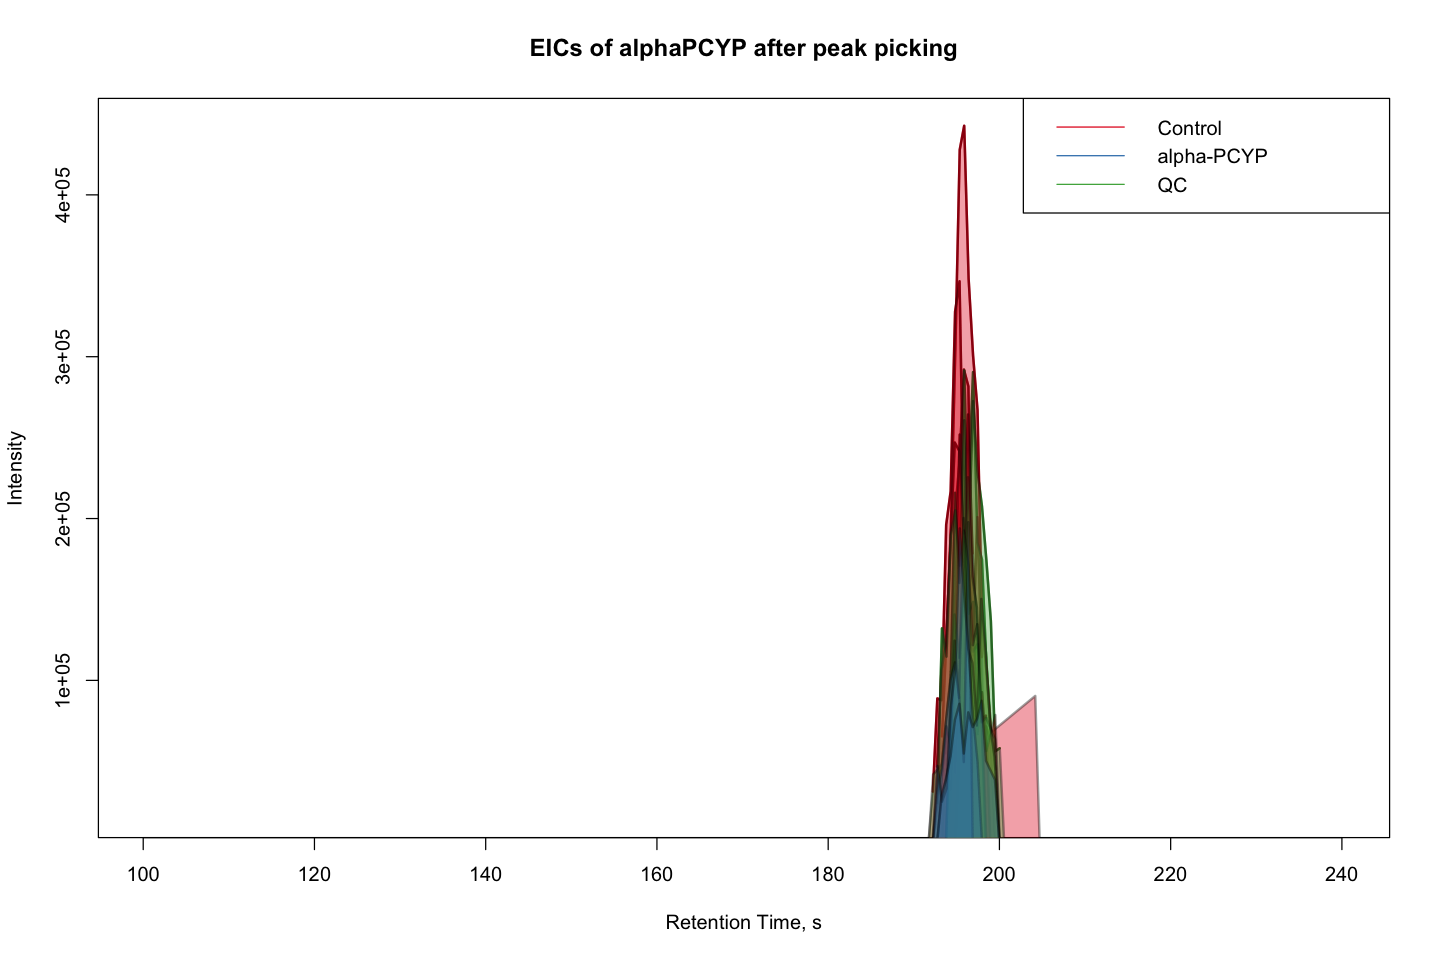

In [61]:
## Plot alpha-PCYP after peak picking (m/z 272.2008, 314 s)
alphaPCYP.picked <- chromatogram(set, mz = c(272.2000, 272.2015), rt = c(100, 240)) 

plot(alphaPCYP.picked, col = group.colours[alphaPCYP.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(alphaPCYP.picked)[, "sample"]],
     main = bquote(bold("EICs of alphaPCYP"*" after peak picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Retention Time Correction

In [62]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.6))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 1.5)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.8, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.2)
    set <- adjustRtime(set, param = pgp)
    
})

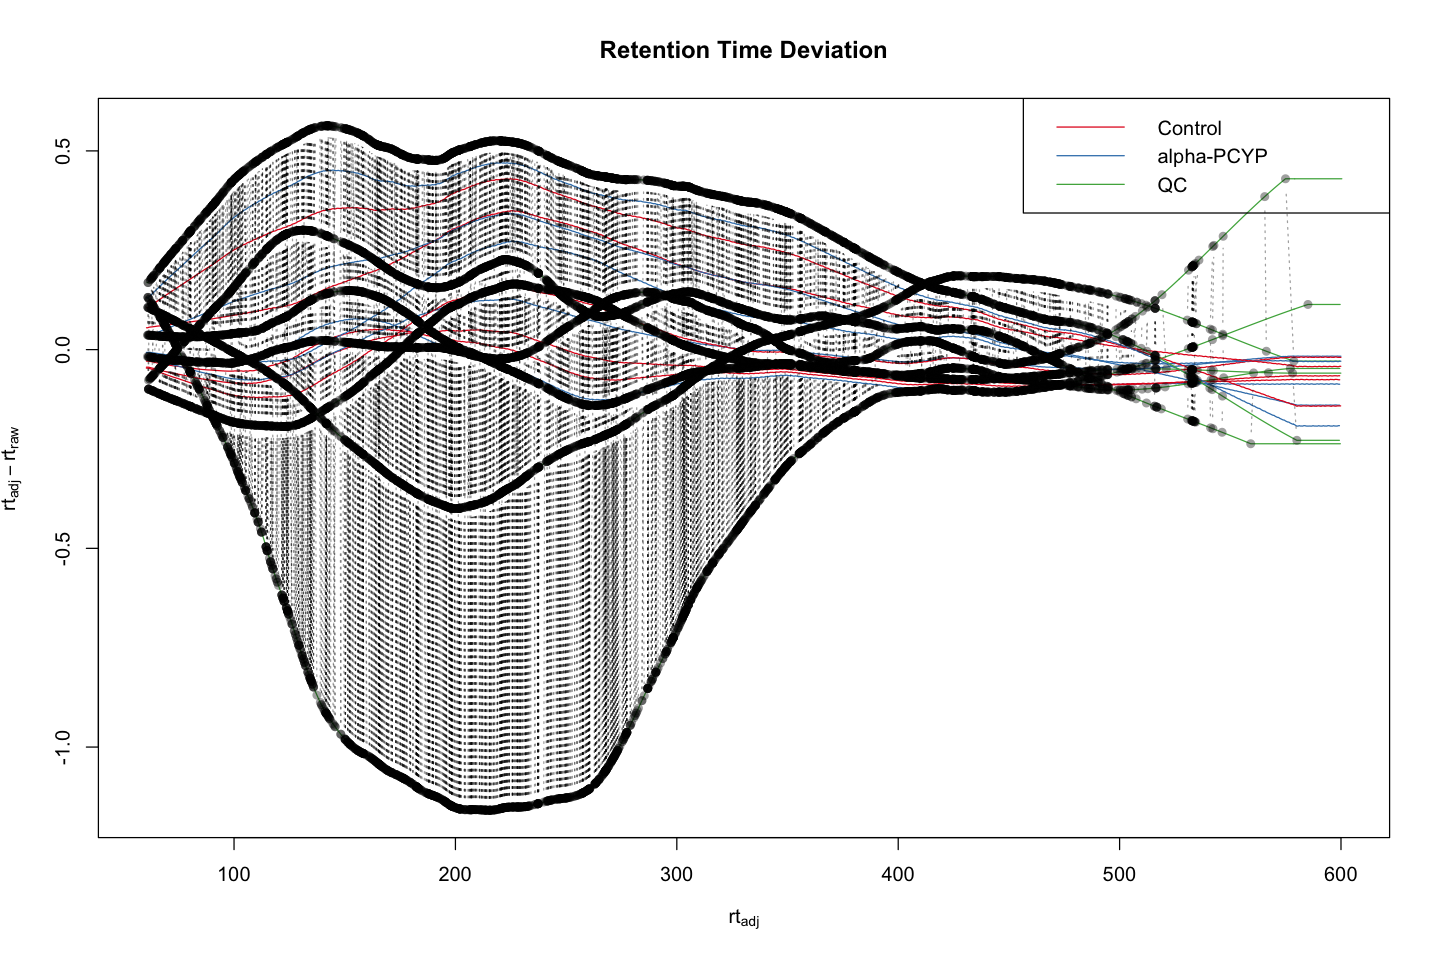

In [63]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

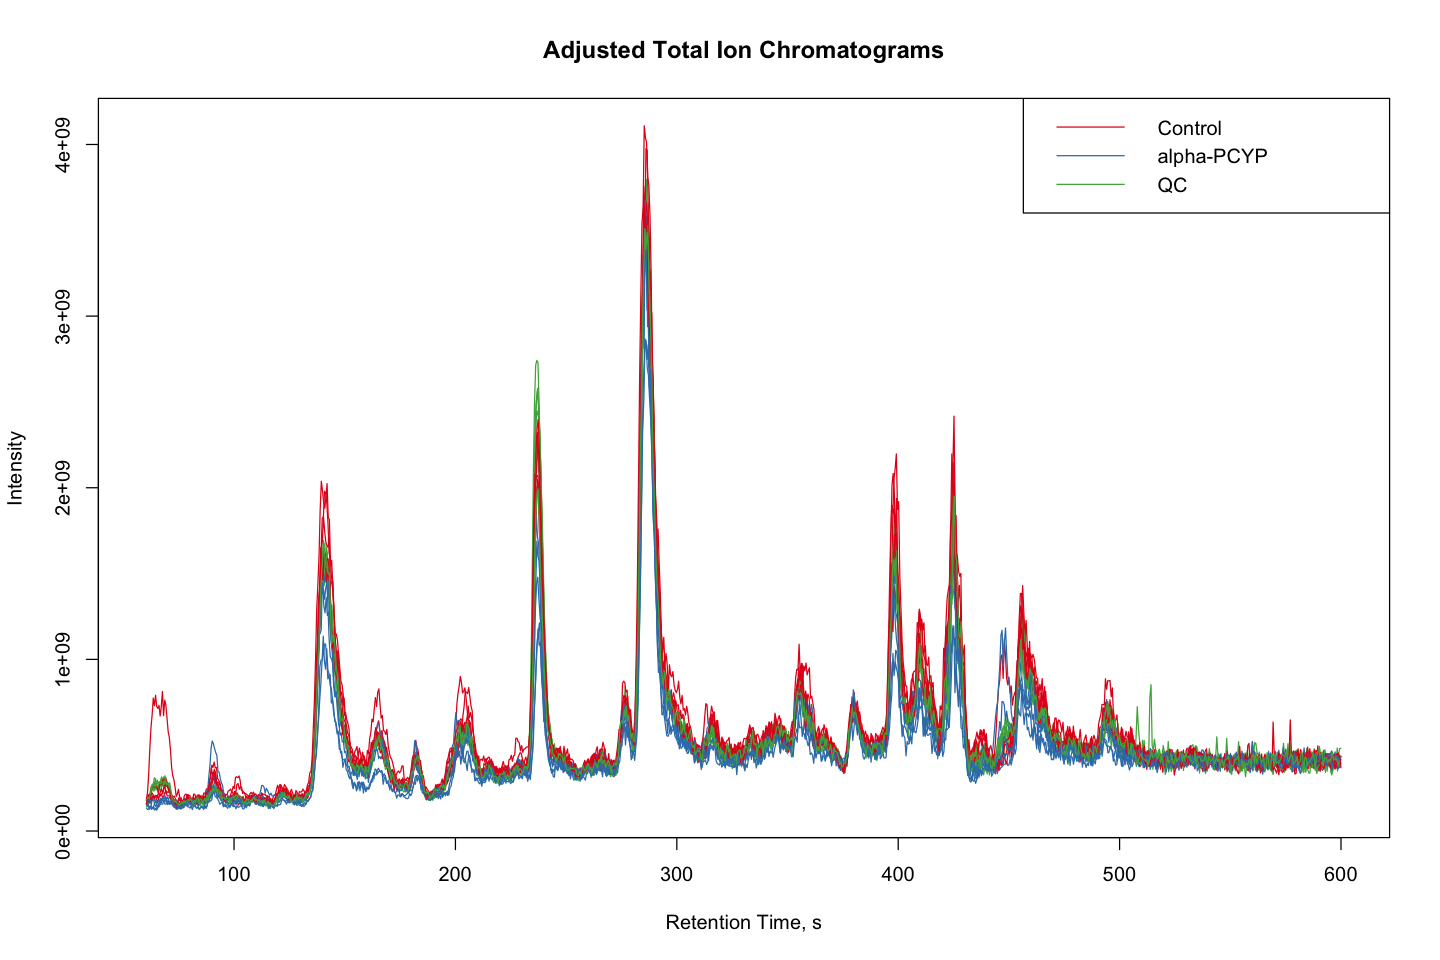

In [64]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

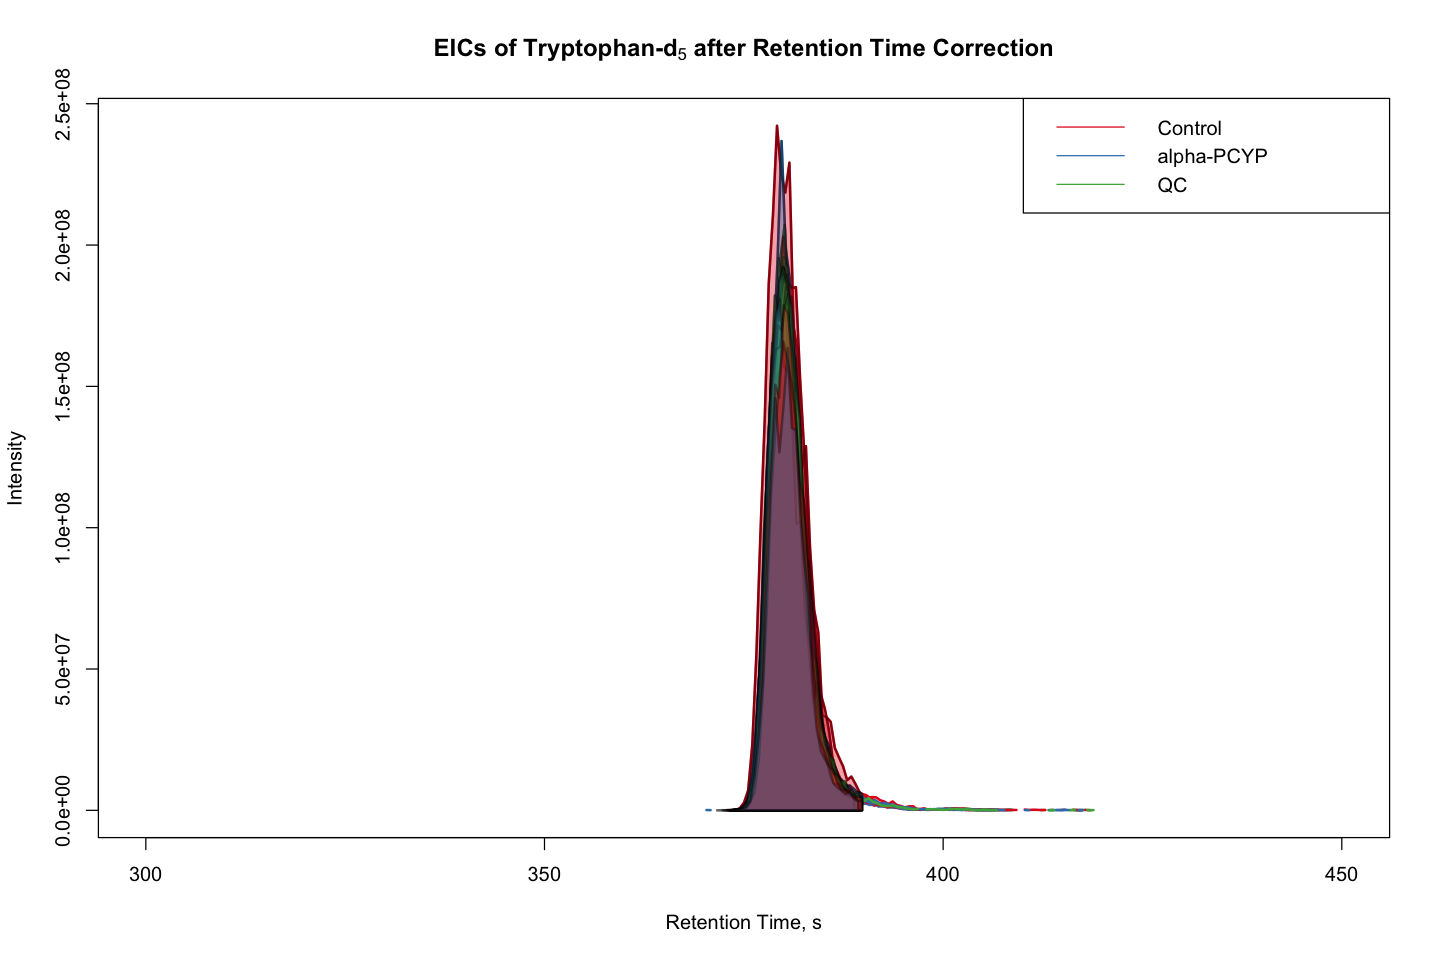

In [65]:
## Plot tryptophan-d5 after retention time correction (m/z 210.1291, 168 s)
trpd5.corr <- chromatogram(set, mz = c(210.1281, 210.1301), rt = c(300, 450))

plot(trpd5.corr, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of Tryptophan-d"[5]*" after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

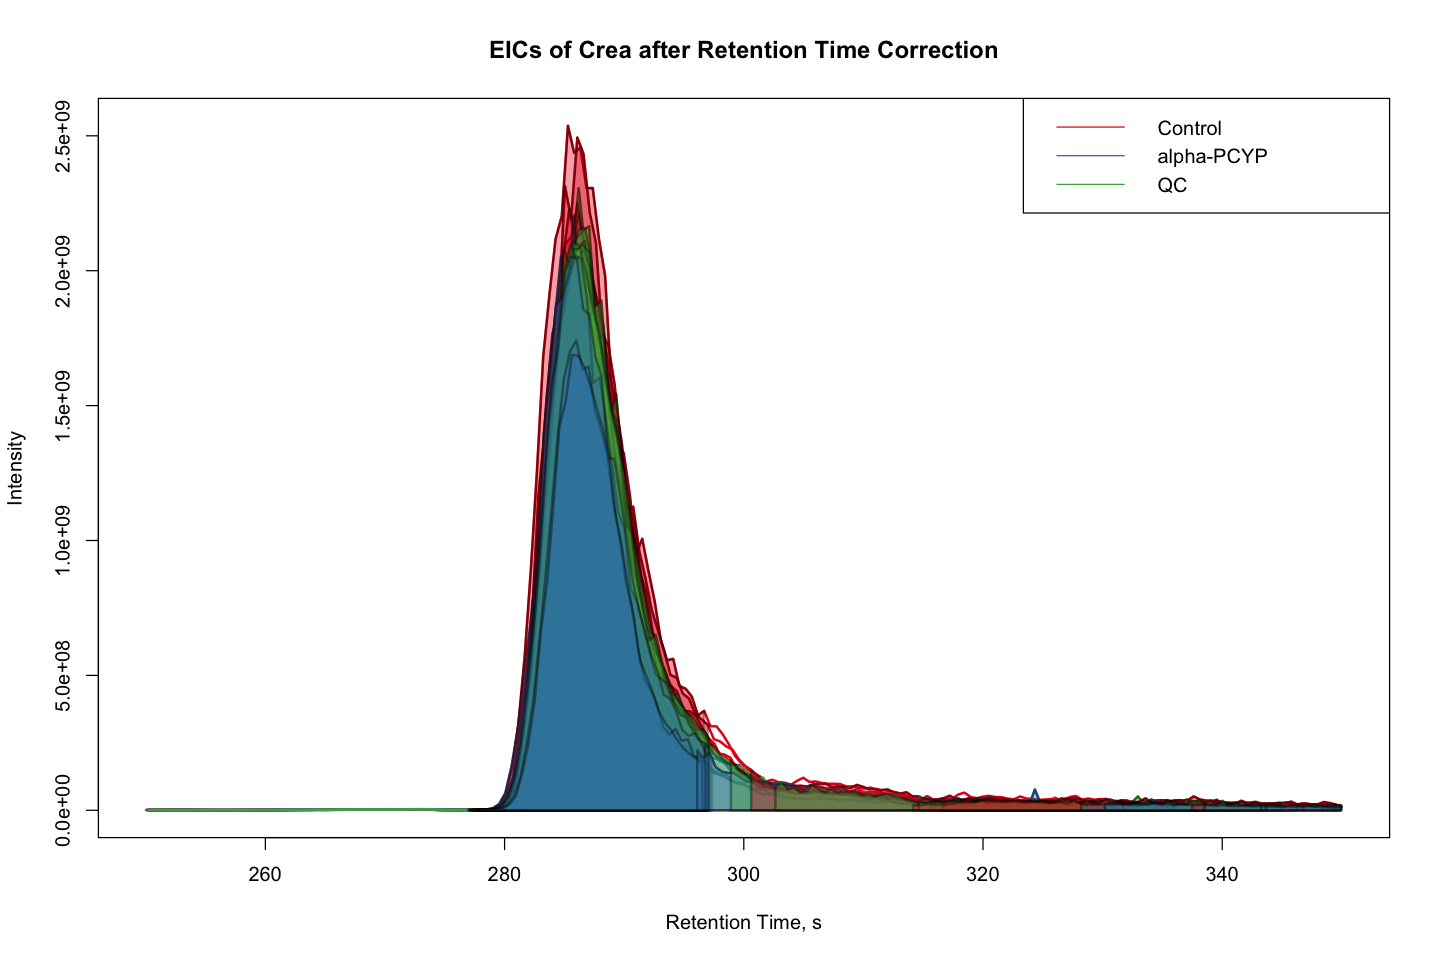

In [66]:
## Plot Crea after after retention time correction (m/z 114.0665, 287 s)
crea.corr <- chromatogram(set, mz = c(114.0645, 114.0685), rt = c(250, 350))

plot(crea.corr, col = group.colours[crea.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(crea.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of Crea after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

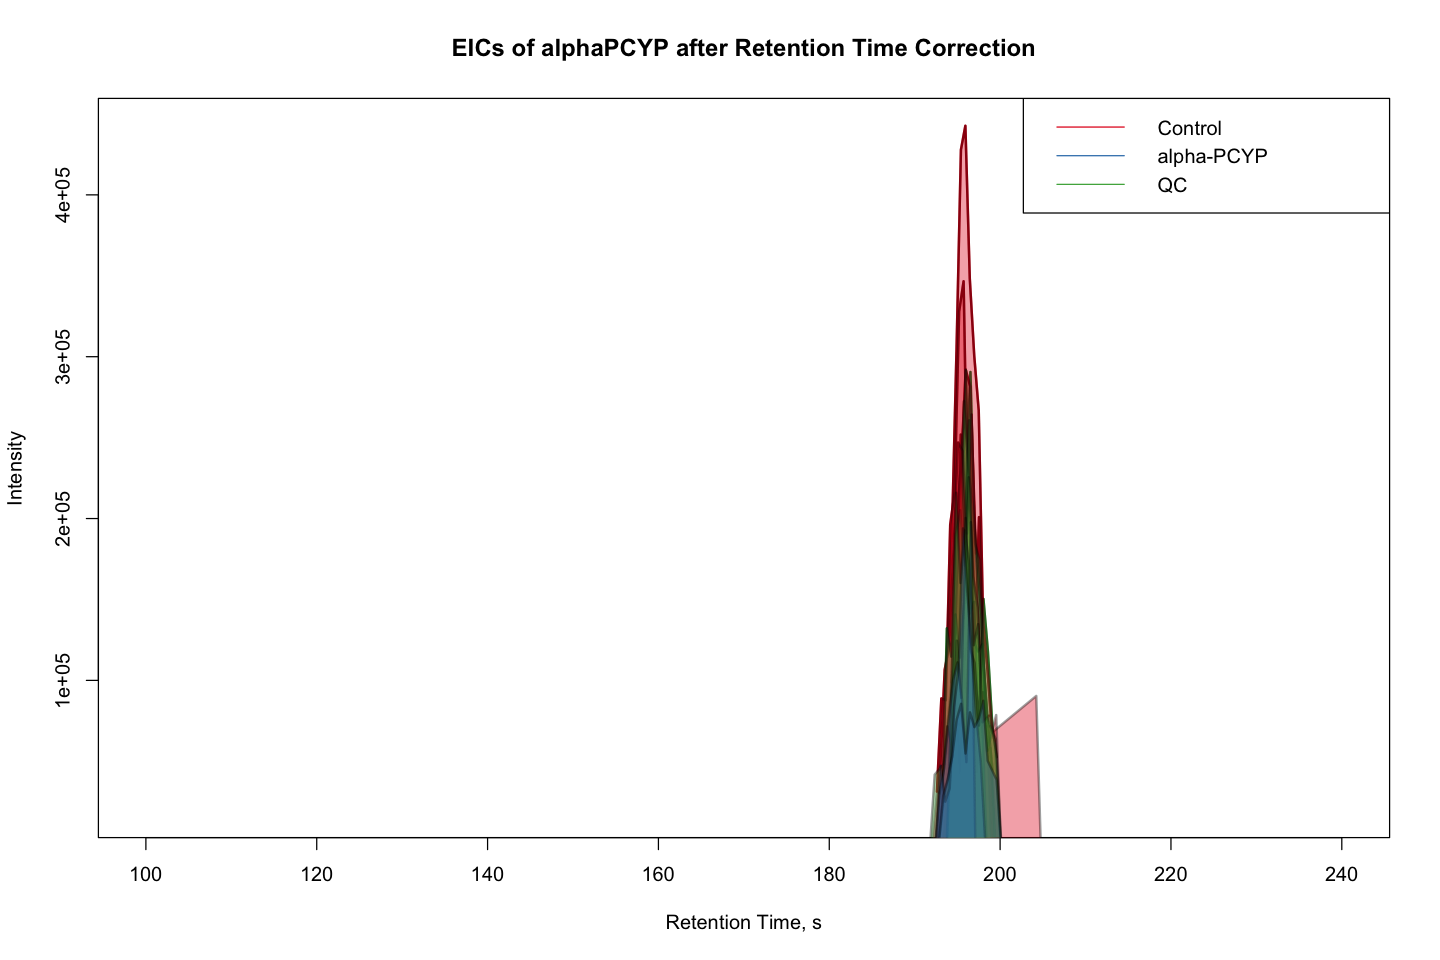

In [67]:
## Plot alpha-PCYP after retention time correction (m/z 272.2008, 314 s)
alphaPCYP.corr <- chromatogram(set, mz = c(272.2000, 272.2015), rt = c(100, 240))

plot(alphaPCYP.corr, col = group.colours[alphaPCYP.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(alphaPCYP.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of alphaPCYP"*" after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Peak Grouping

In [68]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

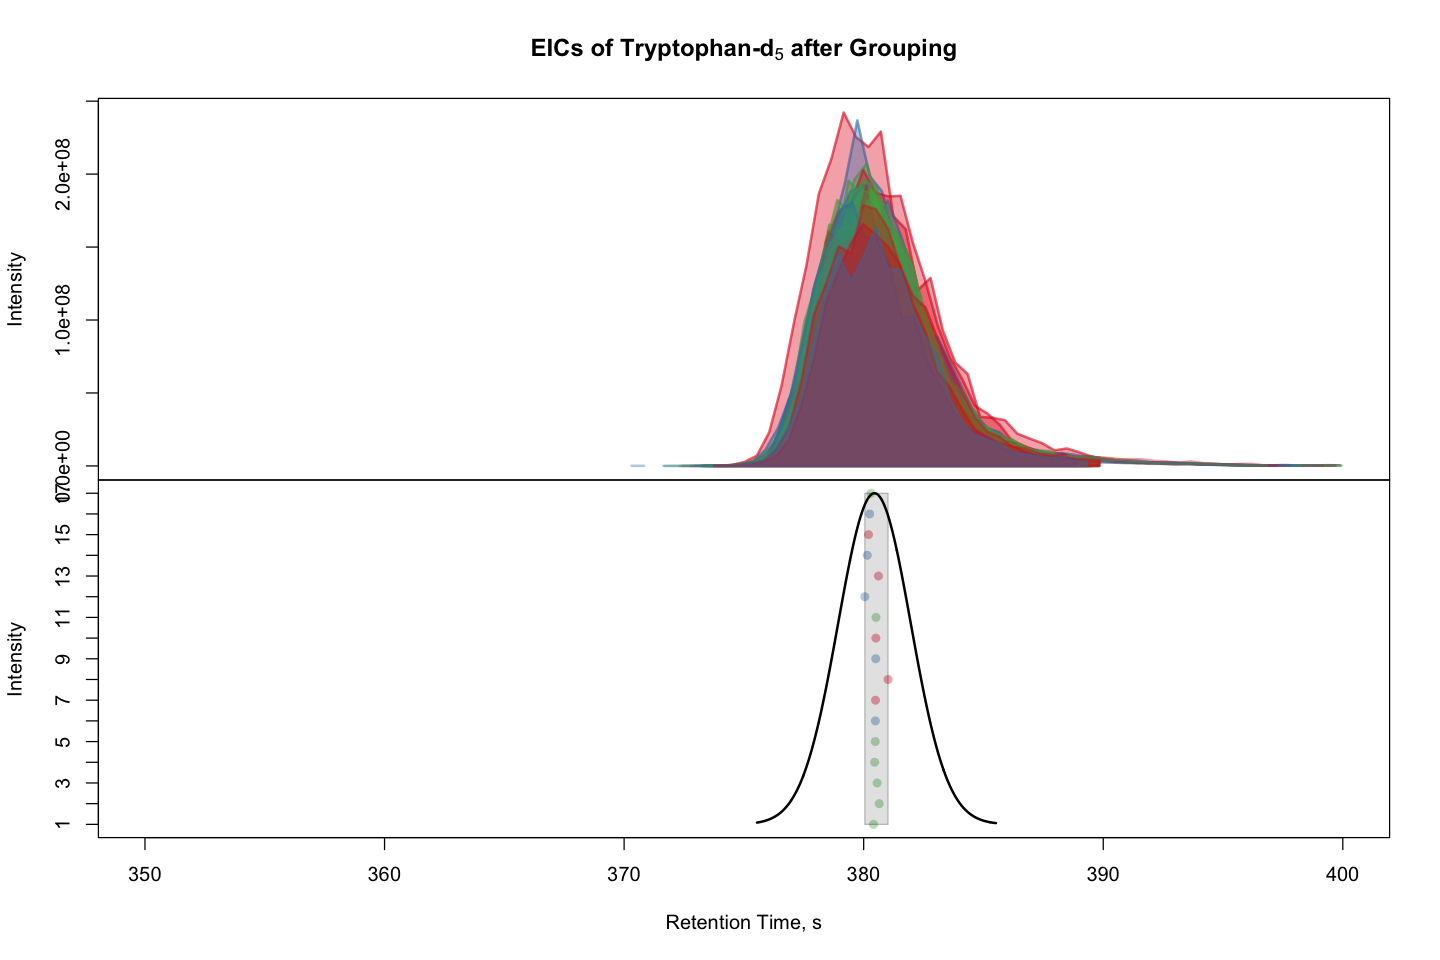

In [69]:
## Plot trp-d5 after peak grouping
trpd5.grouped <- chromatogram(set, mz = c(210.1281, 210.1301), rt = c(350, 400))

## Define the parameters for the peak density method
plotChromPeakDensity(trpd5.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(trpd5.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(trpd5.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Tryptophan-d"[5]*" after Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

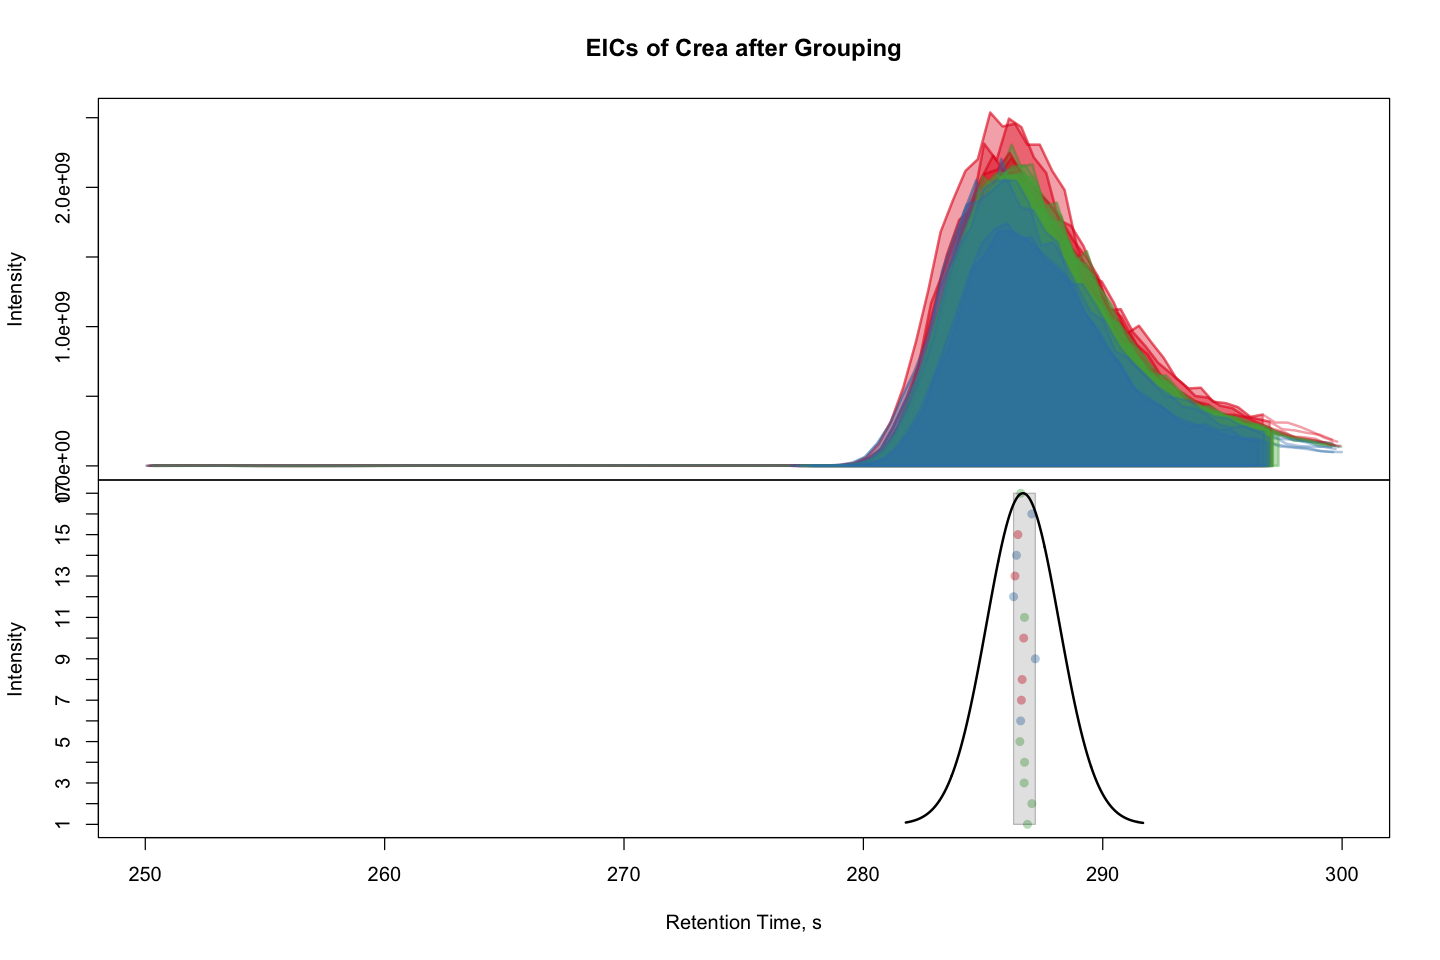

In [71]:
## Plot Crea after peak grouping
crea.grouped <- chromatogram(set, mz = c(114.0645, 114.0685), rt = c(250, 300))

## Define the parameters for the peak density method
plotChromPeakDensity(crea.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(crea.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(crea.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Crea after Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

# Peak Filling

In [72]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'param' bei der Methodenauswahl für Funktion 'fillChromPeaks': konnte Funktion "ChromPeakAreaParam" nicht finden


# Postprocessing


# Annotation of Adducts and Isotopes

In [73]:
## Summarise experiment
results <- quantify(set, value = "into")
class(results)

[1] "SummarizedExperiment"
attr(,"package")
[1] "SummarizedExperiment"

In [74]:
rowData(results) %>%
head()

DataFrame with 6 rows and 12 columns
           mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
       <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT0001   58.0661   58.0661   58.0661   304.822   303.711   305.416         8
FT0002   58.0661   58.0660   58.0662   403.893   403.810   404.336         5
FT0003   59.0739   59.0739   59.0740   448.422   447.934   448.707        11
FT0004   60.0566   60.0565   60.0566   405.408   405.093   405.928        17
FT0005   60.0647   60.0646   60.0647   369.606   369.041   370.659        10
FT0006   61.0406   61.0405   61.0406   237.788   237.085   238.018        17
       alpha.PCYP   Control        QC               peakidx  ms_level
        <numeric> <numeric> <numeric>                <list> <integer>
FT0001          4         1         3  4443, 7153,12556,...         1
FT0002          3         1         1 12841,15460,18339,...         1
FT0003          3         1         7    2375,5043,7762,...        

In [75]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))
rowData(results) %>%
head()

DataFrame with 6 rows and 13 columns
           mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
       <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT0001   58.0661   58.0661   58.0661   304.822   303.711   305.416         8
FT0002   58.0661   58.0660   58.0662   403.893   403.810   404.336         5
FT0003   59.0739   59.0739   59.0740   448.422   447.934   448.707        11
FT0004   60.0566   60.0565   60.0566   405.408   405.093   405.928        17
FT0005   60.0647   60.0646   60.0647   369.606   369.041   370.659        10
FT0006   61.0406   61.0405   61.0406   237.788   237.085   238.018        17
       alpha.PCYP   Control        QC               peakidx  ms_level
        <numeric> <numeric> <numeric>                <list> <integer>
FT0001          4         1         3  4443, 7153,12556,...         1
FT0002          3         1         1 12841,15460,18339,...         1
FT0003          3         1         7    2375,5043,7762,...        

In [76]:
assay(results) %>% 
head()

pQC_1.mzXML pQC_2.mzXML pQC_3.mzXML pQC_4.mzXML pQC_5.mzXML
FT0001          NA    16532795    17746758          NA    16927227
FT0002          NA          NA          NA          NA     5120115
FT0003     6681582     6128320     6265543     6261012     6606105
FT0004    87767835    87142495    89925527    90353858    86170855
FT0005          NA    74246287          NA    37698782          NA
FT0006 12505351985 11895279024 11713549205 11128982070 10323762694
       24h_Urine_Rat_Control_5.mzXML 24h_Urine_Rat_PCYP_4.mzXML
FT0001   18954154                             NA               
FT0002    5093003                        6168139               
FT0003         NA                             NA               
FT0004   73026606                      108460561               
FT0005   34523577                             NA               
FT0006 6767476322                    10254822561               
       24h_Urine_Rat_PCYP_1.mzXML 24h_Urine_Rat_Control_3.mzXML
FT0001         NA                   20831976                   
FT0002         NA                         NA                   
FT0003         NA                   11658002                   
FT0004   90532890                   61503727                   
FT0005   35157579                   80069249                   
FT0006 8448276754                 4566679434                   
       24h_Urine_Rat_PCYP_2.mzXML pQC_6.mzXML 24h_Urine_Rat_Control_2.mzXML
FT0001         NA                         NA    17522640                   
FT0002         NA                         NA     6756027                   
FT0003   17694222                    6590055    21321939                   
FT0004   84194118                   90015059    75406514                   
FT0005   72727322                         NA    39665140                   
FT0006 8336330515                 9388210228  7282763918                   
       24h_Urine_Rat_PCYP_5.mzXML 24h_Urine_Rat_Control_4.mzXML
FT0001         NA                         NA                   
FT0002         NA                    4931521                   
FT0003         NA                         NA                   
FT0004  123197285                   77138221                   
FT0005         NA                   38274155                   
FT0006 9339217154                 5578790059                   
       24h_Urine_Rat_PCYP_3.mzXML 24h_Urine_Rat_Control_1.mzXML pQC_7.mzXML
FT0001   19518228                   18322559                            NA 
FT0002         NA                         NA                            NA 
FT0003         NA                    5197577                       6373473 
FT0004   97407532                   53762613                      84945474 
FT0005         NA                   79000314                      74473586 
FT0006 9266392207                 4453224170                    8311162391

In [77]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "positive") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 146 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  20  30  40  50  60  70  80  90  100  
Found isotopes: 596 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 146 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  

Calculating graph cross linking in 146 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  
New number of ps-groups:  1533 
xsAnnotate has now 1533 groups, instead of 146 
Generating peak matrix for peak annotation!

Calculating possible adducts in 1533 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  


# Scaling

Before log10 transformation, every NA in the data matrix is replaced by the surrogate LOD according to Wehrens et al. at DOI: 10.1007/s11306-016-1015-8. The surrogate LOD is the lowest area that was measured during the analysis.

In [78]:
assays(results)

List of length 1
names(1): raw

In [79]:
# Replacing 0s with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

# Create assay results after log10 transformation
assay(results, "scaled") <- assay(results, "raw") %>%
                            log10()

In [80]:
assays(results)

List of length 2
names(2): raw scaled

In [81]:
results %>%
assay("scaled") %>%
head()

pQC_1.mzXML pQC_2.mzXML pQC_3.mzXML pQC_4.mzXML pQC_5.mzXML
FT0001  5.043928    7.218346    7.249119    5.043928    7.228586  
FT0002  5.043928    5.043928    5.043928    5.043928    6.709280  
FT0003  6.824879    6.787341    6.796959    6.796645    6.819946  
FT0004  7.943335    7.940230    7.953883    7.955947    7.935360  
FT0005  5.043928    7.870675    5.043928    7.576327    5.043928  
FT0006 10.097096   10.075375   10.068689   10.046455   10.013838  
       24h_Urine_Rat_Control_5.mzXML 24h_Urine_Rat_PCYP_4.mzXML
FT0001 7.277704                       5.043928                 
FT0002 6.706974                       6.790154                 
FT0003 5.043928                       5.043928                 
FT0004 7.863481                       8.035272                 
FT0005 7.538116                       5.043928                 
FT0006 9.830427                      10.010928                 
       24h_Urine_Rat_PCYP_1.mzXML 24h_Urine_Rat_Control_3.mzXML
FT0001 5.043928                   7.318730                     
FT0002 5.043928                   5.043928                     
FT0003 5.043928                   7.066624                     
FT0004 7.956806                   7.788901                     
FT0005 7.546019                   7.903466                     
FT0006 9.926768                   9.659601                     
       24h_Urine_Rat_PCYP_2.mzXML pQC_6.mzXML 24h_Urine_Rat_Control_2.mzXML
FT0001 5.043928                   5.043928    7.243600                     
FT0002 5.043928                   5.043928    6.829691                     
FT0003 7.247831                   6.818889    7.328827                     
FT0004 7.925282                   7.954315    7.877409                     
FT0005 7.861698                   5.043928    7.598409                     
FT0006 9.920975                   9.972583    9.862296                     
       24h_Urine_Rat_PCYP_5.mzXML 24h_Urine_Rat_Control_4.mzXML
FT0001 5.043928                   5.043928                     
FT0002 5.043928                   6.692981                     
FT0003 5.043928                   5.043928                     
FT0004 8.090601                   7.887270                     
FT0005 5.043928                   7.582906                     
FT0006 9.970310                   9.746540                     
       24h_Urine_Rat_PCYP_3.mzXML 24h_Urine_Rat_Control_1.mzXML pQC_7.mzXML
FT0001 7.290440                   7.262986                      5.043928   
FT0002 5.043928                   5.043928                      5.043928   
FT0003 5.043928                   6.715801                      6.804376   
FT0004 7.988593                   7.730480                      7.929140   
FT0005 5.043928                   7.897629                      7.872002   
FT0006 9.966911                   9.648675                      9.919662

# Normalisation

In [82]:
## Define function to calculate ppm deviation
ppm <- function(x,y) {

    return(10^6 * (x - y) / y)

}

## Define function to identify row of compound
identify <- function(data, mz, rt, ppmlim, rtlim) {

    delta.mz <- abs(mapply(ppm, x = data$mzmed, y = mz))
    delta.rt <- abs(data$rtmed - rt)
    return(which(delta.mz < ppmlim & delta.rt < rtlim))
    
}

In [83]:
## Identify rownumber of internal standard tryptophan-d5
crea <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 114.0665, rt = 287, 5, 10)

In [84]:
## Normalise data to internal standard
norm.is <- function(x, is){x/x[is]}
assay(results, "norm") <- apply(assay(results, "scaled"),2, norm.is, is = trpd5)

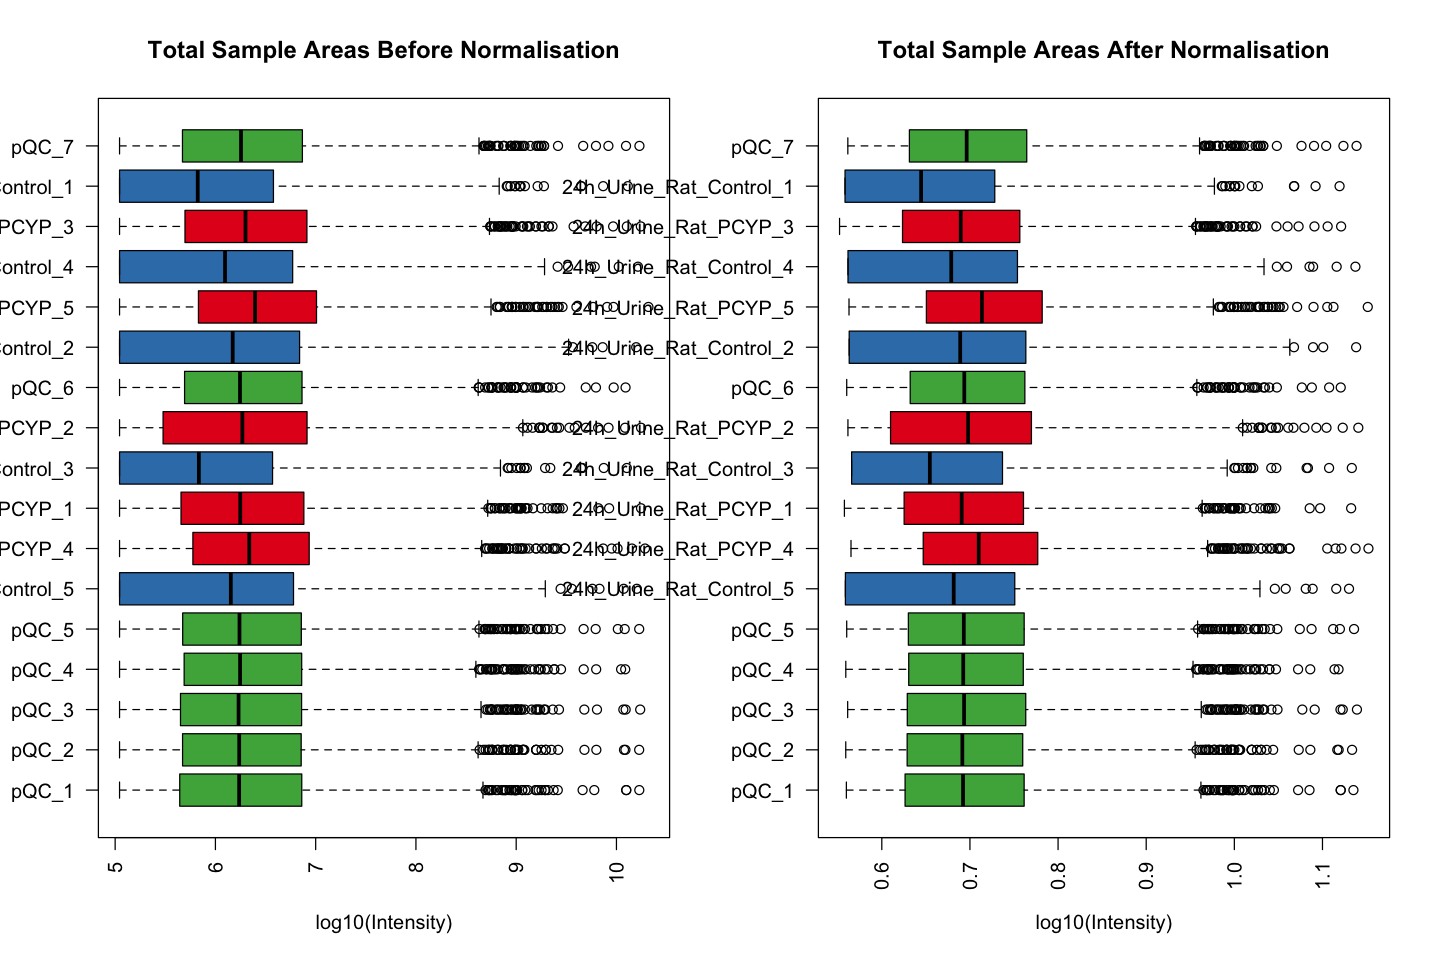

In [85]:
## Compare normalised and unnormalised data
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Normalisation", las = 2)

results %>%
assay("norm") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Normalisation", las = 2)

# Batch correction

In [86]:
## Define function to perform batch correction
batchCorrection <-function(area, order, group, output = c("df", "corr")) {
        
    df <- data.frame(order = order, area = area)
    model <- lm(area ~ order, data = df[group == "QC",])
    df$pred <- predict(model, newdata = df)
    df$corr <- df$corr <- df$area - df$pred + mean (df$area)
    return(switch(output, df = df, corr = df$corr))
    
}

In [87]:
## Filter features by detectability in QC samples
#results.filtered <- results[rowData(results)$QC == 9,]

In [88]:
## Perform batch correction
assay(results, "batchcorr",
      withDimnames = FALSE) <- apply(assay(results, "scaled"), 
                                     1, batchCorrection, 
                                     order = set$sample_order, 
                                     group = set$sample_group, 
                                     output = "corr") %>%
                                     t()

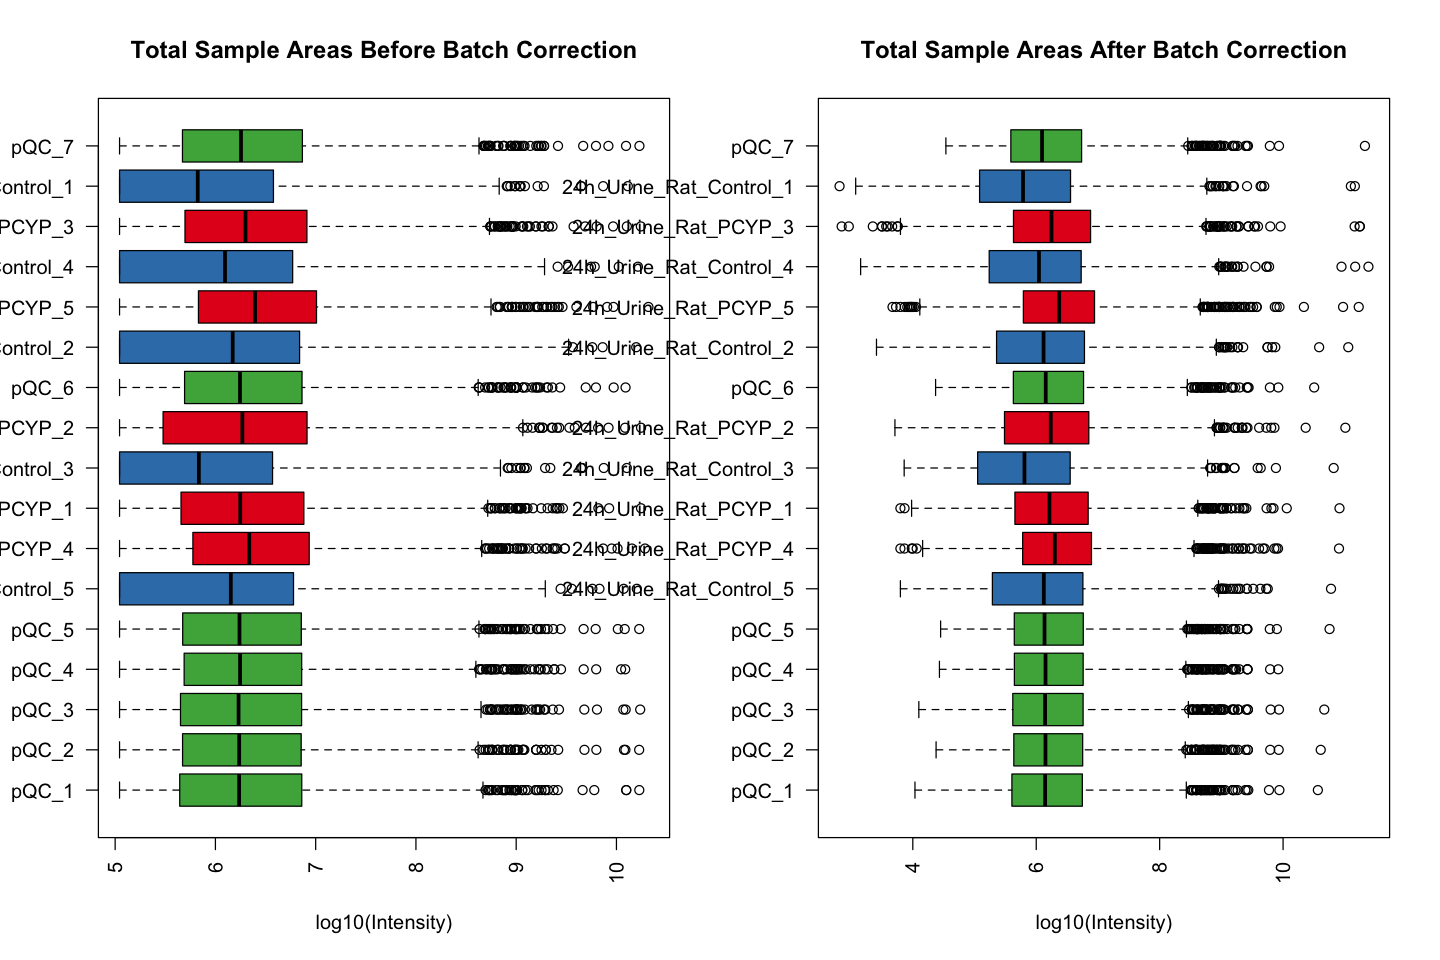

In [89]:
## Compare batch-corrected and uncorrected total sample areas
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Batch Correction", las = 2)

results %>%
assay("batchcorr") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Batch Correction", las = 2)

In [90]:
## Compare batch-corrected and uncorrected areas of compounds
df <- batchCorrection(assay(results, "scaled")[51,], 
                      set$sample_order, set$sample_group, "df")

## Perform regression using corrected values
lm <- lm(area ~ order, data = df[results$sample_group == "QC",])
lm.new <- lm(corr ~ order, data = df[results$sample_group == "QC",])

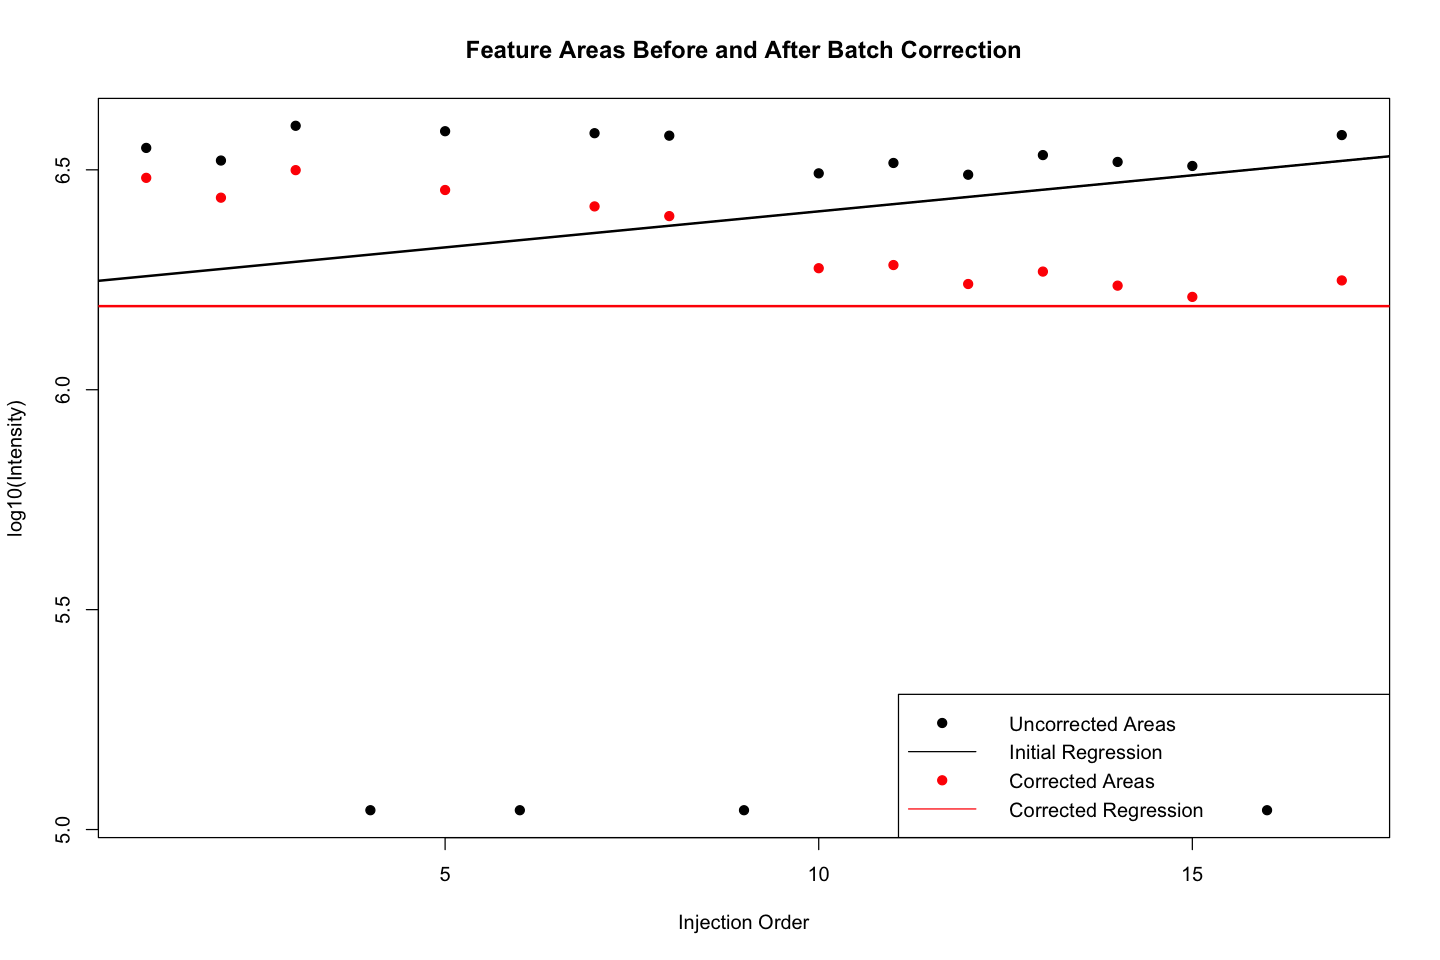

In [91]:
## Plot uncorrected and corrected models and data points
plot(df$order, df$area, col = "black", pch = 19,
     xlab = "Injection Order", ylab = "log10(Intensity)", 
     main = "Feature Areas Before and After Batch Correction")
abline(lm, lwd = 2, col = "black")
points(df$order, df$corr, col = "red", pch = 19)
abline(lm.new, lwd = 2, col = "red")
legend("bottomright", lty = c(NA,1,NA,1), pch=c(19,NA,19,NA),
       legend = c("Uncorrected Areas", "Initial Regression", 
                  "Corrected Areas", "Corrected Regression"), 
       col = c("black", "black", "red", "red"))